In [146]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

# matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

/home/maria/Programs/anaconda3/lib/python3.6/site-packages/matplotlib/backends/__init__.py:60: MatplotlibDeprecationWarning: matplotlib.verbose is deprecated;
Command line argument --verbose-LEVEL is deprecated.
This functionality is now provided by the standard
python logging library.  To get more (or less) logging output:
    import logging
    logger = logging.getLogger('matplotlib')
    logger.set_level(logging.INFO)
  # imports. 0 means only perform absolute imports.
/home/maria/Programs/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:356: MatplotlibDeprecationWarning: matplotlib.verbose is deprecated;
Command line argument --verbose-LEVEL is deprecated.
This functionality is now provided by the standard
python logging library.  To get more (or less) logging output:
    import logging
    logger = logging.getLogger('matplotlib')
    logger.set_level(logging.INFO)
  if self.ge(level):


In [213]:
df = pd.read_csv('extracted_features/df_features_cutted_classes.csv')
print(df.shape)
df.head()

(3418, 99)


,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,22564_Wedding_music.wav,0.115,0.151,1.317,0.716,0.070,0.052,0.145,0.042,129.199,...,0.203,0.293,0.194,0.246,0.248,0.276,0.375,0.271,0.350,8
1,2170_Wedding_music.wav,0.100,0.130,1.386,0.845,0.063,0.013,0.125,0.038,99.384,...,0.219,0.378,0.177,0.295,0.146,0.229,0.356,0.206,0.285,8
2,12235_Dance_music.wav,0.377,0.449,0.377,-0.866,0.055,0.039,0.440,0.088,129.199,...,0.219,0.291,0.283,0.260,0.271,0.307,0.322,0.291,0.294,7
3,4743_Dance_music.wav,0.092,0.120,1.304,0.651,0.128,0.051,0.115,0.032,151.999,...,0.361,0.272,0.322,0.197,0.358,0.253,0.236,0.343,0.197,7
4,17151_Wedding_music.wav,0.192,0.244,1.151,0.294,0.083,0.016,0.236,0.059,92.285,...,0.192,0.385,0.109,0.133,0.103,0.186,0.233,0.138,0.371,8


In [214]:
label_dict = {  #'Background_music':0,
                # 'Theme_music':0,
                'Jingle':0,
                #'Soundtrack_music':1,
                'Lullaby':1,
                'Video_game_music':2,
                'Christmas_music':3,
                'Dance_music':4,
                'Wedding_music':5}
                # 'Birthday_music':9} 

# Normalization of the features
scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_', 1)[1]])
df.head()

,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,22564_Wedding_music.wav,0.130939,0.165733,0.220837,0.010117,0.120567,0.197581,0.159955,0.136213,0.493104,...,0.419643,0.613687,0.406852,0.510791,0.509636,0.589450,0.803965,0.533181,0.700000,5
1,2170_Wedding_music.wav,0.113557,0.142217,0.225012,0.010621,0.108156,0.040323,0.137584,0.122924,0.275864,...,0.455357,0.801325,0.370450,0.628297,0.291221,0.481651,0.762115,0.384439,0.564583,5
2,12235_Dance_music.wav,0.434531,0.499440,0.163964,0.003940,0.093972,0.145161,0.489933,0.289037,0.493104,...,0.455357,0.609272,0.597430,0.544365,0.558887,0.660550,0.687225,0.578947,0.583333,4
3,4743_Dance_music.wav,0.104287,0.131019,0.220051,0.009864,0.223404,0.193548,0.126398,0.102990,0.659230,...,0.772321,0.567329,0.680942,0.393285,0.745182,0.536697,0.497797,0.697941,0.381250,4
4,17151_Wedding_music.wav,0.220162,0.269877,0.210794,0.008470,0.143617,0.052419,0.261745,0.192691,0.224139,...,0.395089,0.816777,0.224839,0.239808,0.199143,0.383028,0.491189,0.228833,0.743750,5


In [215]:
# Train-test split of files # Same split as used for VGG model
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[1:-1]], 
                                                    df['label'],
                                                    random_state = 10, 
                                                    test_size = 0.2
                                                    )

# Among the test files, keep half for validation
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                random_state = 10, 
                                                test_size = 0.5
                                                )


In [216]:
experiment_path = 'remove_background_theme_soundtrack/'
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig('plots/' + experiment_path + title.replace(" ", "_") +'.png', bbox_inches='tight')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True, cm_title='Confustion matrix'):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        roles = ['Jingle', 'Lullaby', 'Video_game', 'Christmas',
        'Dance', 'Wedding']#, 'Birthday'] # for beatiful plotting
        plot_confusion_matrix(confusion_matrix(y_test[:len(pred)], pred), classes=roles, title=cm_title)

### Logistic Regression
LR is usually done for binary classification tasks. For this multi-class classification task, the LR is implemented as a one-vs-rest method. That is, 7 separate classifiers are trained. During test time, the class with the highest prob. from among the 7 classifiers is the predicted class.

Accuracy =  0.53
F-score =  0.52
ROC AUC = 0.837
Confusion matrix, without normalization
[[26  3  4 13 12  1]
 [ 1 36  4  4  0  5]
 [ 4  4 36  3 10  8]
 [16 13  6 11  3  6]
 [ 8  0  1  3 33  5]
 [ 5  4  7  6  2 39]]
CPU times: user 381 ms, sys: 8.01 ms, total: 389 ms
Wall time: 387 ms


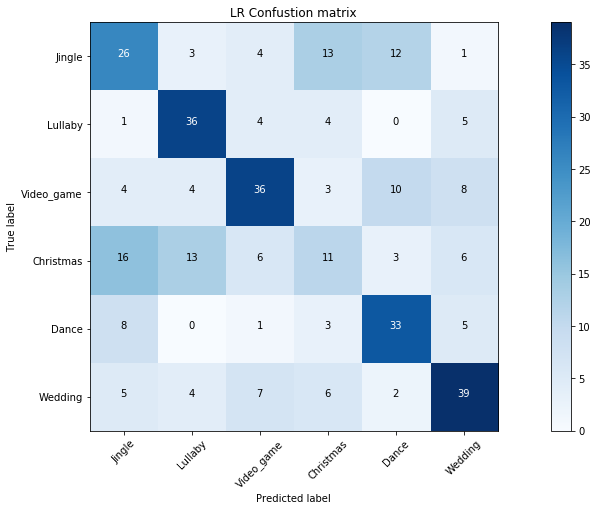

In [217]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, y_train)

# Prediction for validation set 
pred_probs = lr_classifier.predict_proba(x_val)
display_results(y_val, pred_probs, cm_title='LR Confustion matrix')
# Save
with open('pred_probas/lr_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
# Prediction for test set
pred_probs_LR = lr_classifier.predict_proba(x_test)
# Save
with open('pred_probas/lr_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_LR, f)

### Random Forest

Accuracy =  0.59
F-score =  0.58
ROC AUC = 0.856
Confusion matrix, without normalization
[[32  3  3  8 10  3]
 [ 2 36  1  3  1  7]
 [ 5  4 35  7 10  4]
 [14 12  2 17  3  7]
 [ 7  0  0  3 37  3]
 [ 5  4  5  3  2 44]]
CPU times: user 6.44 s, sys: 12 ms, total: 6.45 s
Wall time: 6.45 s


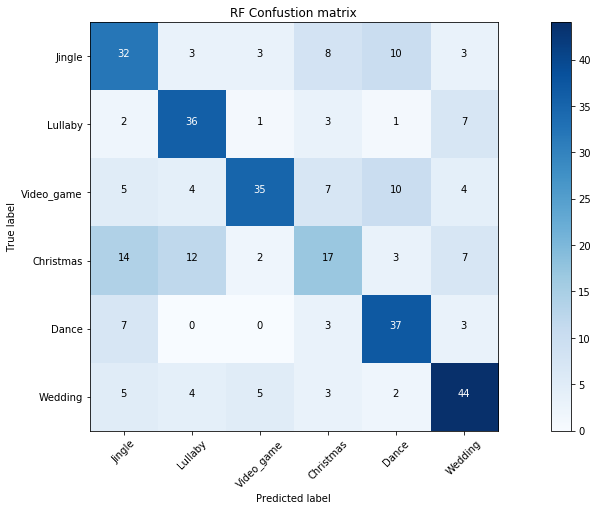

In [226]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, y_train)

# Predict (validation set)
pred_probs = rf_classifier.predict_proba(x_val)
display_results(y_val, pred_probs, cm_title='RF Confustion matrix')

# Save
with open('pred_probas/rf_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
# Prediction for test set
pred_probs_RF = rf_classifier.predict_proba(x_test)
# Save
with open('pred_probas/rf_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_RF, f)

### Gradient Boosting 

Accuracy =  0.58
F-score =  0.58
ROC AUC = 0.850
Confusion matrix, without normalization
[[26  2  4 12 13  2]
 [ 1 36  2  4  1  6]
 [ 4  2 37  4 15  3]
 [13  8  1 23  2  8]
 [ 5  0  0  6 36  3]
 [ 7  6  3  5  2 40]]
CPU times: user 43.7 s, sys: 3.84 ms, total: 43.7 s
Wall time: 43.7 s


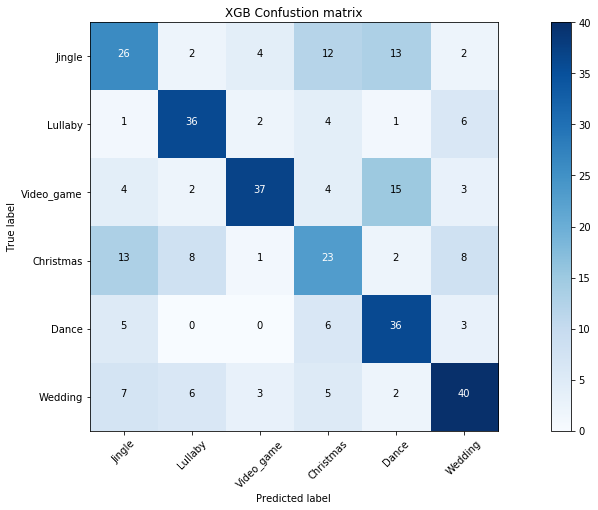

In [219]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Prediction and result (validation set)
pred_probs = xgb_classifier.predict_proba(x_val)
display_results(y_val, pred_probs, cm_title='XGB Confustion matrix')

# Save
with open('pred_probas/xgb_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
        
# Prediction for test set
pred_probs_XGB = xgb_classifier.predict_proba(x_test)
# Save
with open('pred_probas/xgb_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_XGB, f)

### Support Vector Machines

Accuracy =  0.51
F-score =  0.52
ROC AUC = 0.838
Confusion matrix, without normalization
[[22  1  3 15 15  3]
 [ 2 34  2  4  0  8]
 [ 6  2 35  8  9  5]
 [15  7  4 20  1  8]
 [ 9  1  3  4 30  3]
 [ 4  7  5  9  3 35]]
CPU times: user 14.4 s, sys: 24 ms, total: 14.4 s
Wall time: 14.4 s


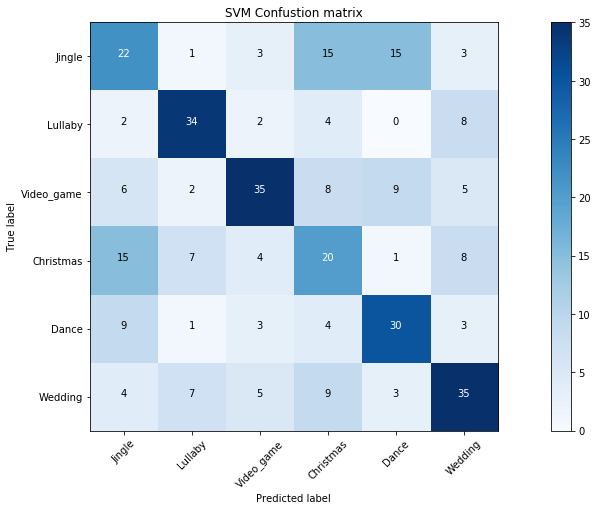

In [220]:
%%time
# Train
svm_classifier = SVC(C=10000.0, probability = True, kernel='rbf') # class_weight=cl_weight,
svm_classifier.fit(x_train, y_train)

# Predict (validation set)
pred_probs = svm_classifier.predict_proba(x_val)

# Results
display_results(y_val, pred_probs, cm_title='SVM Confustion matrix')

# Save
with open('pred_probas/svm_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
        
# Prediction for test set
pred_probs_SVM = svm_classifier.predict_proba(x_test)
# Save
with open('pred_probas/svm_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_SVM, f)

### Most Important Feature
Determine the features that contribute the most towards making the correct classfication

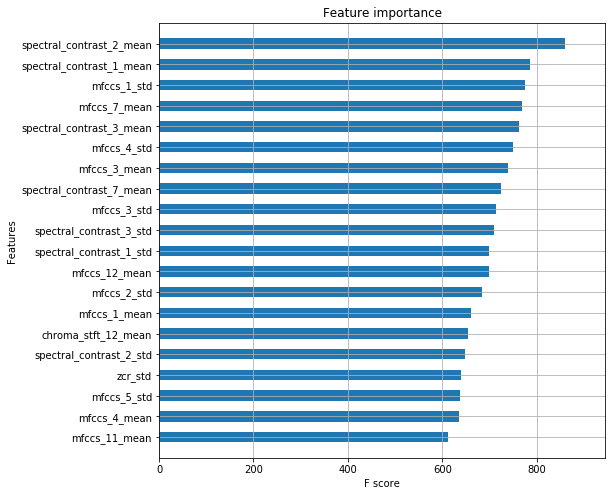

In [222]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=20, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
# plt.savefig('plots/feature-imp.png', bbox_inches='tight')

The most important features seem to be MFCCs and spectral contrast (mean and std dev in different frequency bins). Use the top N features, build the model and look at the metrics

In [223]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.00510866, 0.00688472, 0.00955878, 0.01171399, 0.01083594,
       0.01275169, 0.00321287, 0.01111532, 0.01037696, 0.00738361,
       0.01071621, 0.00556764, 0.00608649, 0.0052683 , 0.00690467,
       0.        , 0.        , 0.01570513, 0.0171619 , 0.0152262 ,
       0.01129493, 0.01197342, 0.01133484, 0.01444793, 0.01396899,
       0.01295125, 0.01414859, 0.01079603, 0.00983816, 0.01219293,
       0.01011754, 0.00778272, 0.00730379, 0.01317076, 0.00894015,
       0.01474726, 0.01269182, 0.00939913, 0.01127497, 0.01536589,
       0.01177386, 0.01083594, 0.01135479, 0.01223284, 0.01394903,
       0.00973838, 0.00975834, 0.01087586, 0.01177386, 0.0099978 ,
       0.01093572, 0.01009758, 0.01195346, 0.01546567, 0.01366965,
       0.01426832, 0.01494682, 0.01273174, 0.01059648, 0.01071621,
       0.01099559, 0.00977829, 0.01021732, 0.00907984, 0.00915967,
       0.01105546, 0.01165413, 0.00712418, 0.0080621 , 0.00854104,
       0.01081599, 0.0089202 , 0.00830157, 0.01057652, 0.00989

In [227]:
top_n = [10, 20, 30, 50, 60]
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_val = selection.transform(x_val)
    #select_x_train = x_train.iloc[:, :n]
    #select_x_val = x_val.iloc[:, :n]
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                       n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
    select_xgb_classifier.fit(select_x_train, y_train)
    #svm_classifier = SVC(C=10000.0, probability = True, kernel='rbf') # class_weight=cl_weight,
    #svm_classifier.fit(select_x_train, y_train)
    #pred_probs = svm_classifier.predict_proba(select_x_val)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_val)

    # Results
    display_results(y_val, pred_probs, cm = False)     
    print()

Stats for top 10 features:
Accuracy =  0.47
F-score =  0.47
ROC AUC = 0.778

Stats for top 20 features:
Accuracy =  0.53
F-score =  0.53
ROC AUC = 0.826

Stats for top 30 features:
Accuracy =  0.55
F-score =  0.55
ROC AUC = 0.837

Stats for top 50 features:
Accuracy =  0.58
F-score =  0.58
ROC AUC = 0.847

Stats for top 60 features:
Accuracy =  0.58
F-score =  0.58
ROC AUC = 0.850



### Ensemble of XGB and VGG

In [61]:
# Load predicted probabilities
with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/vgg_fine_tuning.pkl', 'rb') as f:
    vgg_pred_probs = pickle.load(f)
    
n_samples = np.min([len(xgb_pred_probs), len(vgg_pred_probs)])

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs[:n_samples] + vgg_pred_probs[:n_samples])/2.0

# Show metrics
display_results(y_test[:n_samples], ensemble_pred_probs)

ValueError: operands could not be broadcast together with shapes (514,9) (514,7) 

### Plot 3 ROCs the same graph
- VGG
- XGB
- Ensemble

In [8]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class

def plot_roc_curves(y_true, pred_probs, label_dict):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    NUM_CLASSES = len(label_dict)
    one_hot_true = one_hot_encoder(y_true, len(y_true), NUM_CLASSES)
    for i in range(len(label_dict)):
        fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES

    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

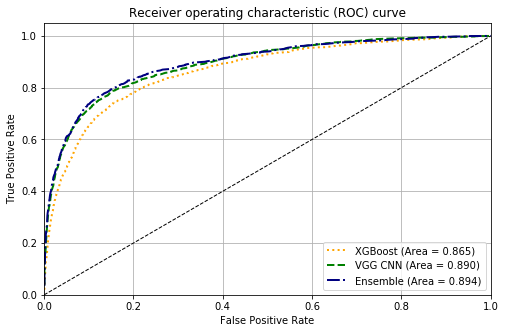

In [9]:
# Plot all ROC curves
plt.figure(figsize=(8,5))

plt.title('Macro-average ROC curves')

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], xgb_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='XGBoost (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='orange', linestyle=':', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], vgg_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='VGG CNN (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='green', linestyle='--', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], ensemble_pred_probs[:n_samples]
                                    , label_dict)
plt.plot(fpr, tpr,
         label='Ensemble (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='navy', linestyle='-.', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
# plt.savefig('plots/roc-curve.png')
plt.show()

#### Time Domain Feature Only

Test Set Accuracy =  0.40
Test Set F-score =  0.34
ROC AUC = 0.731
Confusion matrix, without normalization
[[183  60   8  16  10  34  53]
 [ 59 143  17  12   8 106  38]
 [ 24  32  56   4   2  33  20]
 [ 78  47  12  10  13  41  31]
 [ 40  35   5   5  20  13  14]
 [ 27  70  10   7   7 252  43]
 [ 48  53  12   9   8  62 137]]
CPU times: user 1min 23s, sys: 16.1 ms, total: 1min 23s
Wall time: 1min 23s


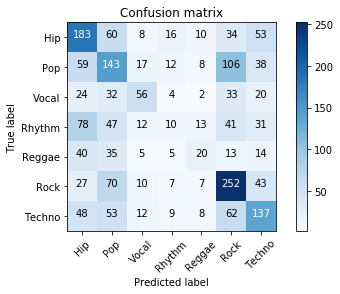

In [14]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,:9], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,:9])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_time_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

#### Frequency Domain Feature Only

Test Set Accuracy =  0.57
Test Set F-score =  0.53
ROC AUC = 0.857
Confusion matrix, without normalization
[[230  55  10  14  16  14  25]
 [ 55 203  18  19   6  52  30]
 [ 12  11 106   6   4  18  14]
 [ 44  62   5  46  19  31  25]
 [ 25  32   5  14  43   8   5]
 [ 13  50   8   5   1 317  22]
 [ 23  31  11   7   3  51 203]]
CPU times: user 17min 8s, sys: 28 ms, total: 17min 8s
Wall time: 17min 8s


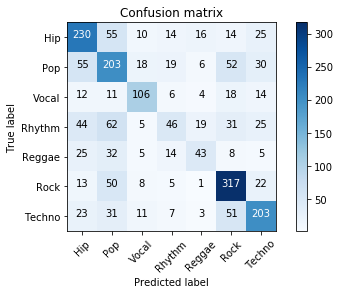

In [15]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,9:], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,9:])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_freq_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)